# PCA ATTEMPT

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.api import Logit, add_constant
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
from sklearn.impute import SimpleImputer


# Load the dataset
merged_df = pd.read_csv('merged_df.csv')

# Display the first few rows of the dataset to ensure it loaded correctly
print(merged_df.head())


   Unnamed: 0      ID  group  outcome  age  gendera       BMI  hypertensive  \
0           1  100213      1        0   74        2  26.81457             1   
1           2  100449      2        0   87        1  24.00000             1   
2           3  100571      1        0   67        1  32.28435             1   
3           4  100610      1        0   81        2       NaN             1   
4           5  100660      1        0   75        1       NaN             1   

   atrialfibrillation  CHD with no MI  ...  admission_type  \
0                   0               0  ...       EMERGENCY   
1                   0               0  ...       EMERGENCY   
2                   0               0  ...       EMERGENCY   
3                   1               0  ...       EMERGENCY   
4                   0               0  ...       EMERGENCY   

          admission_location       discharge_location  insurance  language  \
0  CLINIC REFERRAL/PREMATURE  LONG TERM CARE HOSPITAL   Medicare       NaN

In [16]:
# Identify and drop any non-numeric columns if they exist
# Assuming 'outcome' is the only non-numeric column needed
non_numeric_cols = merged_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
print(f"Non-numeric columns to be dropped: {non_numeric_cols}")
data = merged_df.drop(columns=non_numeric_cols)

# Separate the outcome variable
outcome = data['outcome']
data = data.drop(columns=['outcome'])

# Ensure all remaining columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Remove columns with NA values that could not be converted to numeric
data = data.dropna(axis=1, how='any')

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Remove columns with zero variance
data_var = pd.DataFrame(standardized_data, columns=data.columns)
data_var = data_var.loc[:, (data_var != data_var.iloc[0]).any()]

# Verify that there are no zero variance columns
print(f"Columns retained after removing zero variance columns: {data_var.shape[1]}")

# Apply PCA
pca = PCA()
pc_data = pca.fit_transform(data_var)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio of each principal component: {explained_variance}")

# Convert to DataFrame for ease of use
pc_df = pd.DataFrame(pc_data, columns=[f'PC{i+1}' for i in range(pc_data.shape[1])])

# Combine principal components with the outcome variable
pca_data = pd.concat([pc_df, outcome.reset_index(drop=True)], axis=1)

# Fit the full logistic regression model using principal components
X = add_constant(pca_data.drop(columns=['outcome']))
y = pca_data['outcome']

# Fit the model
full_model = Logit(y, X).fit()
print(full_model.summary())

# Perform stepwise selection based on AIC
def stepwise_selection(X, y):
    initial_list = X.columns.tolist()
    best_model = Logit(y, X).fit()
    best_aic = best_model.aic
    improved = True
    
    while improved:
        improved = False
        results = []
        
        # Try dropping each column
        for column in initial_list:
            temp_X = X.drop(columns=[column])
            model = Logit(y, temp_X).fit(disp=0)
            results.append((model.aic, column, model))
        
        # Try adding each column
        for column in [col for col in data.columns if col not in initial_list]:
            temp_X = X.join(data[column])
            model = Logit(y, temp_X).fit(disp=0)
            results.append((model.aic, column, model))
        
        results.sort()
        best_aic, best_column, best_model = results[0]
        
        if best_aic < best_model.aic:
            improved = True
            initial_list = best_model.params.index.tolist()
    
    return best_model

best_model = stepwise_selection(X, y)
print(best_model.summary())


Non-numeric columns to be dropped: ['admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'diagnosis', 'hospital_expire_flag']
Columns retained after removing zero variance columns: 33
Explained variance ratio of each principal component: [1.09072129e-01 8.22930626e-02 6.66611481e-02 6.15933642e-02
 5.35715691e-02 5.11805663e-02 4.61982382e-02 4.21848423e-02
 3.82590947e-02 3.55825747e-02 3.35821011e-02 3.23057834e-02
 3.01572197e-02 2.92823905e-02 2.75982435e-02 2.68134648e-02
 2.62863238e-02 2.53305497e-02 2.44232083e-02 2.15535707e-02
 2.11021851e-02 1.99087028e-02 1.79548271e-02 1.64467352e-02
 1.62897412e-02 1.51350117e-02 1.19663142e-02 9.06791865e-03
 7.95846524e-03 1.78887167e-04 3.28011251e-05 2.42889990e-05
 4.67636432e-06]
Optimization terminated successfully.
         Current function value: 0.298325
         Iterations 7
                           Logit Regres

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# Identify and drop any non-numeric columns if they exist
non_numeric_cols = merged_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
data = merged_df.drop(columns=non_numeric_cols)

# Separate the outcome variable
outcome = data['outcome']
data = data.drop(columns=['outcome'])

# Ensure all remaining columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Remove columns with NA values that could not be converted to numeric
data = data.dropna(axis=1, how='any')

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Remove columns with zero variance
data_var = pd.DataFrame(standardized_data, columns=data.columns)
data_var = data_var.loc[:, (data_var != data_var.iloc[0]).any()]

# Apply PCA
pca = PCA(n_components=15)  # Use fewer components to avoid overfitting and convergence issues
pc_data = pca.fit_transform(data_var)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio of each principal component: {explained_variance}")

# Convert to DataFrame for ease of use
pc_df = pd.DataFrame(pc_data, columns=[f'PC{i+1}' for i in range(pc_data.shape[1])])

# Combine principal components with the outcome variable
pca_data = pd.concat([pc_df, outcome.reset_index(drop=True)], axis=1)

# Define feature matrix X and target vector y
X = pca_data.drop(columns=['outcome'])
y = pca_data['outcome']

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Perform cross-validation
kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(log_reg, X, y, cv=kf, scoring='accuracy')
print(f'Cross-validated accuracy: {np.mean(scores)}')

# Fit the logistic regression model
log_reg.fit(X, y)

# Print the coefficients
print("Coefficients:", log_reg.coef_)
print("Intercept:", log_reg.intercept_)


Explained variance ratio of each principal component: [0.10907213 0.08229305 0.06666105 0.06159336 0.05357156 0.05117935
 0.04619623 0.0421825  0.0382578  0.03557852 0.03358205 0.03230014
 0.03015345 0.0292744  0.02759743]
Cross-validated accuracy: 0.8733970429138118
Coefficients: [[ 0.28686481 -0.03308509  0.16200427  0.06817541 -0.3449347  -0.45776827
   0.24813199  0.24555397 -0.38811828 -0.06028523 -0.04562862 -0.1014447
   0.25321004 -0.03578662  0.20614294]]
Intercept: [-2.30517768]


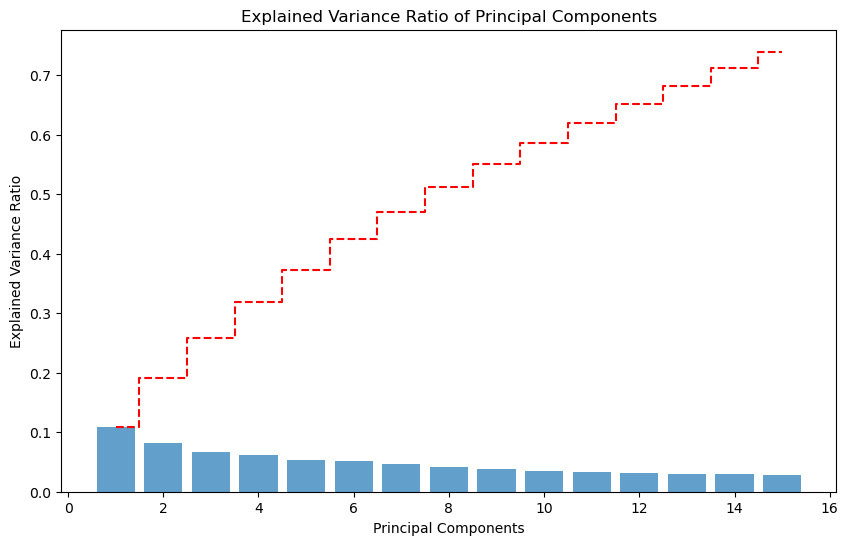

In [18]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
#bars
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
#red line
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', linestyle='--', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()


In [19]:
# Identify and drop any non-numeric columns if they exist
non_numeric_cols = merged_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
data = merged_df.drop(columns=non_numeric_cols)

# Separate the outcome variable
outcome = data['outcome']
data = data.drop(columns=['outcome'])

# Ensure all remaining columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Remove columns with NA values that could not be converted to numeric
data = data.dropna(axis=1, how='any')

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Remove columns with zero variance
data_var = pd.DataFrame(standardized_data, columns=data.columns)
data_var = data_var.loc[:, (data_var != data_var.iloc[0]).any()]

# Apply PCA
pca = PCA(n_components=15)  # Use fewer components to avoid overfitting and convergence issues
pc_data = pca.fit_transform(data_var)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio of each principal component: {explained_variance}")

# Convert to DataFrame for ease of use
pc_df = pd.DataFrame(pc_data, columns=[f'PC{i+1}' for i in range(pc_data.shape[1])])

# Combine principal components with the outcome variable
pca_data = pd.concat([pc_df, outcome.reset_index(drop=True)], axis=1)

# Define feature matrix X and target vector y
X = pca_data.drop(columns=['outcome'])
y = pca_data['outcome']

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Perform cross-validation
kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(log_reg, X, y, cv=kf, scoring='accuracy')
print(f'Cross-validated accuracy: {np.mean(scores)}')

# Fit the logistic regression model
log_reg.fit(X, y)

# Print the coefficients
print("Coefficients:", log_reg.coef_)
print("Intercept:", log_reg.intercept_)

# Calculate the loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pc_data.shape[1])], index=data.columns)
print(loadings)

# Identify the most influential features in each principal component
top_features_per_pc = {}
for i in range(1, 16):
    pc_loadings = loadings[f'PC{i}'].sort_values(ascending=False)
    top_features_per_pc[f'PC{i}'] = pc_loadings.index[:5].tolist()  # Top 5 features for each PC

print("Top features per principal component:")
for pc, features in top_features_per_pc.items():
    print(f"{pc}: {features}")


Explained variance ratio of each principal component: [0.10907213 0.08229297 0.06666084 0.06159295 0.05357074 0.05117925
 0.04619687 0.04218039 0.03825205 0.03558202 0.03357769 0.03228259
 0.02999455 0.02926984 0.02758056]
Cross-validated accuracy: 0.8716913090515688
Coefficients: [[ 0.28765968 -0.0310133   0.1627294   0.06834431 -0.34601729 -0.45830591
   0.24946489  0.24614374 -0.38391361 -0.05958309 -0.04754298 -0.09419811
  -0.25148964 -0.04914014  0.20472769]]
Intercept: [-2.30423364]
                         PC1       PC2       PC3       PC4       PC5  \
Unnamed: 0         -0.012021  0.035356  0.074732  0.671389 -0.158956   
ID                 -0.012409  0.034992  0.074822  0.671426 -0.158425   
group              -0.012467  0.029073  0.028167 -0.011057 -0.024801   
age                 0.040046 -0.105623 -0.000546 -0.111301 -0.285998   
gendera            -0.052093 -0.026987 -0.218667 -0.004980  0.023681   
hypertensive        0.058481  0.012043  0.037886 -0.059965 -0.077649   
a

In [20]:
# Assuming merged_df is your DataFrame
# merged_df = pd.read_csv('your_data.csv')  # Uncomment this if you need to load your data

# List of columns to exclude (e.g., identifiers)
exclude_columns = ['subject_id']

# Filter out non-numeric columns and exclude specific columns
numeric_df = merged_df.select_dtypes(include=[np.number]).drop(columns=exclude_columns)

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
numeric_df_imputed = imputer.fit_transform(numeric_df)

# Standardize the data (optional but recommended for PCA)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numeric_df_imputed)

# Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Get explained variance ratio and PCA components
explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_

# Calculate the cumulative explained variance to decide the number of components to retain
cumulative_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_variance >= 0.70) + 1  # Retain components that explain at least 70% variance

# Create a DataFrame to store the feature loadings
loadings = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(len(components))], index=numeric_df.columns)

# Sum the absolute values of the loadings for the retained components
top_loadings = loadings.iloc[:, :num_components].abs().sum(axis=1)

# Number of features to select
x = 10

# Select the top features based on their summed loadings
top_features = top_loadings.nlargest(x).index.tolist()  

print("Top", x,  "features selected based on PCA loadings:", top_features)


Top 10 features selected based on PCA loadings: ['gendera', 'Systolic blood pressure', 'Hyperlipemia', 'depression', 'Diastolic blood pressure', 'Platelets', 'PH', 'INR', 'PT', 'MCV']


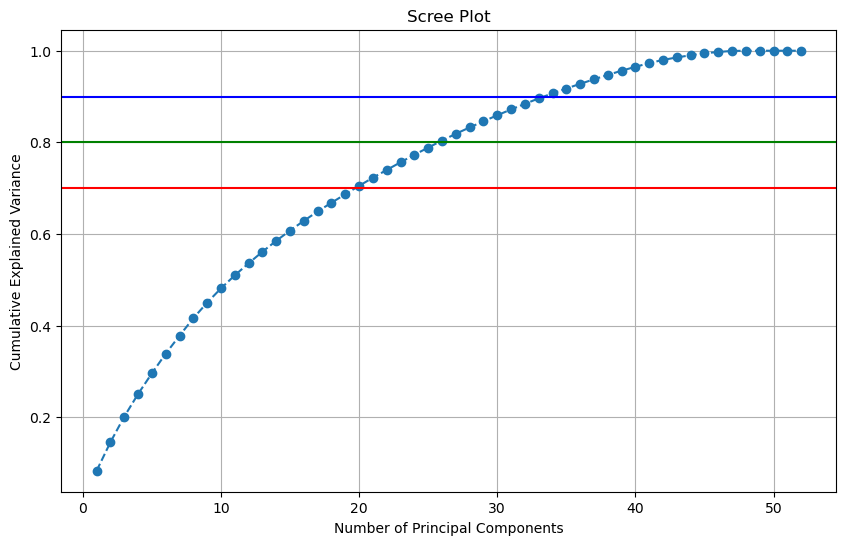

In [21]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.70, color='r', linestyle='-')
plt.axhline(y=0.80, color='g', linestyle='-')
plt.axhline(y=0.90, color='b', linestyle='-')
plt.grid()
plt.show()
